# Setup
---

## Module Imports

In [41]:
from treetime.utils import parse_dates
from treetime import TreeTime
from treetime import plot_vs_years

from Bio import Phylo

import random
import copy

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import cm
import matplotlib.ticker as ticker
import matplotlib

import seaborn as sns

#from datetime import datetime
import datetime
import pandas as pd
from scipy import stats
import numpy as np

## Input File Paths

In [2]:
meta_path = "../Assembly_Modern/nextstrain/metadata_nextstrain_geocode_state.tsv"
tree_path = "../Assembly_Modern/iqtree/iqtree.core-filter0_bootstrap.treefile"
aln_path = "../Assembly_Modern/snippy_multi/snippy-core.full_CHROM.filter0.fasta"

## Constants and Variables

In [3]:
NO_DATA_CHAR = "?"
OUTGROUP = ["GCA_000323485.1_ASM32348v1_genomic",
            "GCA_000323845.1_ASM32384v1_genomic"]

# Preferred values: slack=0.1, coupling=0.5
# Current exp: 
#   reduce slack: 1.0->0.1 (slightly reduces node estimates, fold rate=46)
#      I think 0.1 is appropriately low for the wild rate variation 
#   increase coupling: 0.5->1.0 (pushes modern nodes too far back)

slack = 0.1
coupling = 0.5
confidence = 0.95
# Offset for mutations: 0 will be 1-based
offset = 0
# Branch Length Optimization
# For more divergent sequences, iterative optimization will underestimate the branch lengths
# What is "divergent"? treetime data is a lot of epidemic viral phylo, so I think bacterial history is divergent
# Shaw et al. (2019) finds that joint is inappropriate (because topology is fixed), classical marginal is fine?
bl_mode = "input"
ml_mode = "marginal" # Shaw et al. (2019) demonstrate joint is bad
title = "Autocorrelated Relaxed Clock"
file_prefix = "autocorrelated-relaxed-clock"

present = datetime.date.today().year

random.seed(131495)

## Parse Dates

In [4]:
dates = parse_dates(date_file=meta_path, date_col="BioSampleCollectionDate")
# Create a dict of samples with ambiguous dates to exclude from rtt
dates_ambig = {}
for sample in dates:
    # If list range specified, add to ambiguity dict
    if type(dates[sample]) == type([]):
        dates_ambig[sample] = dates[sample]


Attempting to parse dates...
	Using column 'strain' as name. This needs match the taxon names in the tree!!
	Using column 'BioSampleCollectionDate' as date.


## Parse Tree

In [5]:
tree = Phylo.read(tree_path, "newick")
tree_tip_names = [t.name for t in tree.get_terminals()]

# Clock Analysis
---

In [6]:
tt_relaxed = TreeTime(tree = tree_path,
                      aln = aln_path,
                      verbose = 4,
                      dates = dates)


0.00	-TreeAnc: set-up

77.24	-SequenceData: loaded alignment.

77.24	-SeqData: making compressed alignment...

191.18	-SequenceData: constructed compressed alignment...
211.27	--ClockTree: Setting precision to level 2

211.28	-ClockTree._assign_dates: assigned date contraints to 476 out of 476
      	 tips.


In [7]:
tt_relaxed.run(branch_length_mode = bl_mode,
               n_iqd=3,
               root=None,
               infer_gtr=True,
               resolve_polytomies=False,
               relaxed_clock={"slack":slack, "coupling":coupling},
               max_iter=3,
               Tc="skyline",
               use_covariation=False,
               vary_rate=False,
               time_marginal="assign",
               sequence_marginal=True,
               verbose=4,
              )


211.29	-TreeAnc.infer_ancestral_sequences with method: probabilistic, marginal

211.29	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences
      	of tips at positions with AMBIGUOUS bases. This resulted in unexpected
      	behavior is some cases and is no longer done by default. If you want to
      	replace those ambiguous sites with their most likely state, rerun with
      	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.
211.29	--TreeAnc._ml_anc_marginal: type of reconstruction: Marginal
211.29	---Attaching sequence profiles to leafs...
211.72	---Postorder: computing likelihoods...
212.05	---Computing root node sequence and total tree likelihood...
212.06	---Preorder: computing marginal profiles...
212.68	---TreeAnc._ml_anc_marginal: ...done
212.71	--TreeAnc.infer_gtr: counting mutations...
213.75	---TreeAnc.infer_gtr: counting mutations...done

213.75	-GTR: with alphabet: ['A', 'C', 'G', 'T', '-']
213.75	--GTR: ambiguous character: N
213.75	---GTR

253.78	--ClockTree - Marginal reconstruction:  Propagating root -> leaves...
293.66	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
293.66	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
293.66	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
293.66	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
293.66	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
293.66	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
293.66	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
293.66	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"

451.64	---Computing root node sequence and total tree likelihood...
451.64	---Preorder: computing marginal profiles...
452.01	---TreeAnc._ml_anc_marginal: ...done

452.14	###TreeTime.run: FINAL ROUND - confidence estimation via marginal
      	reconstruction

452.14	-ClockTree: Maximum likelihood tree optimization with temporal
      	 constraints
452.14	--ClockTree.init_date_constraints...
452.14	---ClockTree.init_date_constraints: Initializing branch length
      	   interpolation objects...
453.25	--ClockTree.date2dist: Setting new molecular clock. rate=4.348e-08,
      	  R^2=0.0035
453.26	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
453.26	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
453.26	----ClockTree.init_date_constraints -- WA

'success'

### Add Node Comments

In [8]:
for n in tt_relaxed.tree.find_clades():
    # Add mutations comment
    if n.mutations:
        mut_comment = 'mutations="' + ','.join([a+str(pos + offset)+d for (a,pos, d) in n.mutations
                                                              if tt_relaxed.gtr.ambiguous not in [a,d]])+'"'
        if n.comment:
            n.comment = ",".join([n.comment, mut_comment])
        else:
            n.comment = "&" + mut_comment
    # Add date comment
    if n.numdate:
        date_comment = 'date={:.2f}'.format(n.numdate)
        if n.comment:
            n.comment = ",".join([n.comment, date_comment])
        else:
            n.comment = "&" + date_comment

# Stats

In [30]:
# Dates Confidence File Header
fh_dates = open("{}_dates.tsv".format(file_prefix), 'w', encoding='utf-8')
fh_dates.write('#Lower and upper bound delineate the {0:.0f}% max posterior region\n'.format(confidence*100))
fh_dates.write('#node\tdate\tnumeric date\tlower bound\tupper bound\n')

for n in tt_relaxed.tree.find_clades():
    if n.bad_branch:
        fh_dates.write('%s\t--\t--\t--\t--\n'%(n.name))
    else:
        conf = tt_relaxed.get_max_posterior_region(n, fraction=confidence) 
        fh_dates.write('%s\t%s\t%f\t%f\t%f\n'%(n.name, n.date, n.numdate,conf[0], conf[1]))
#--------------

# Substition File Header
fh_rates = open("{}_rates.tsv".format(file_prefix), 'w')
fh_rates.write("#node\tclock_length\tmutation_length\trate\tfold_change\n")

min_gamma = ['', 1]
max_gamma = ['', 1]
gamma_dict = {}

for n in tt_relaxed.tree.find_clades(order="preorder"):
    if n==tt_relaxed.tree.root:
        continue
    g = n.branch_length_interpolator.gamma
    if g <= min_gamma[1]:
        min_gamma[0] = n.name
        min_gamma[1] = g
    if g >= max_gamma[1]:
        max_gamma[0] = n.name
        max_gamma[1] = g
    fh_rates.write("%s\t%1.3e\t%1.3e\t%1.3e\t%1.2f\n"%(n.name, n.clock_length, n.mutation_length, tt_relaxed.date2dist.clock_rate*g, g))
    # Add the rate change to comments
    n.comment = ",".join([n.comment, "gamma={:.2f}".format(g)])
    gamma_dict[n.name] = g
    
print("min_gamma: ", min_gamma)
print("max_gamma: ", max_gamma)
print("ratio: ", max_gamma[1] / min_gamma[1])

min_gamma:  ['GCA_000269405.1_ASM26940v1_genomic', 0.1]
max_gamma:  ['GCA_000834275.1_ASM83427v1_genomic', 4.605844377932564]
ratio:  46.058443779325636


# Plotting

## Root-To-Tip Regression

### Setup Data

In [10]:
# Lists to store the x and y coordinates
full_dist2root = []
full_date = []

tt_relaxed_rtt = copy.deepcopy(tt_relaxed)

# Change branch lengths back to mutation length
for c in tt_relaxed_rtt.tree.find_clades():
    c.branch_length = c.mutation_length

# Create a dataframe that does not include the outgroup or samples with amiguous dates
for t in tt_relaxed_rtt.tree.get_terminals():
    if (t.name not in OUTGROUP) and (t.name not in dates_ambig):
        full_dist2root.append(tt_relaxed_rtt.tree.distance(tt_relaxed_rtt.tree.root, t))
        full_date.append(t.date)

df = pd.DataFrame({
          "dist2root" : full_dist2root,
          "date": full_date
         })

df['date_ordinal'] = pd.to_datetime(df['date']).apply(lambda date: date.toordinal())

### Plot

r2:  0.025290631208453842
Num Taxa:  440


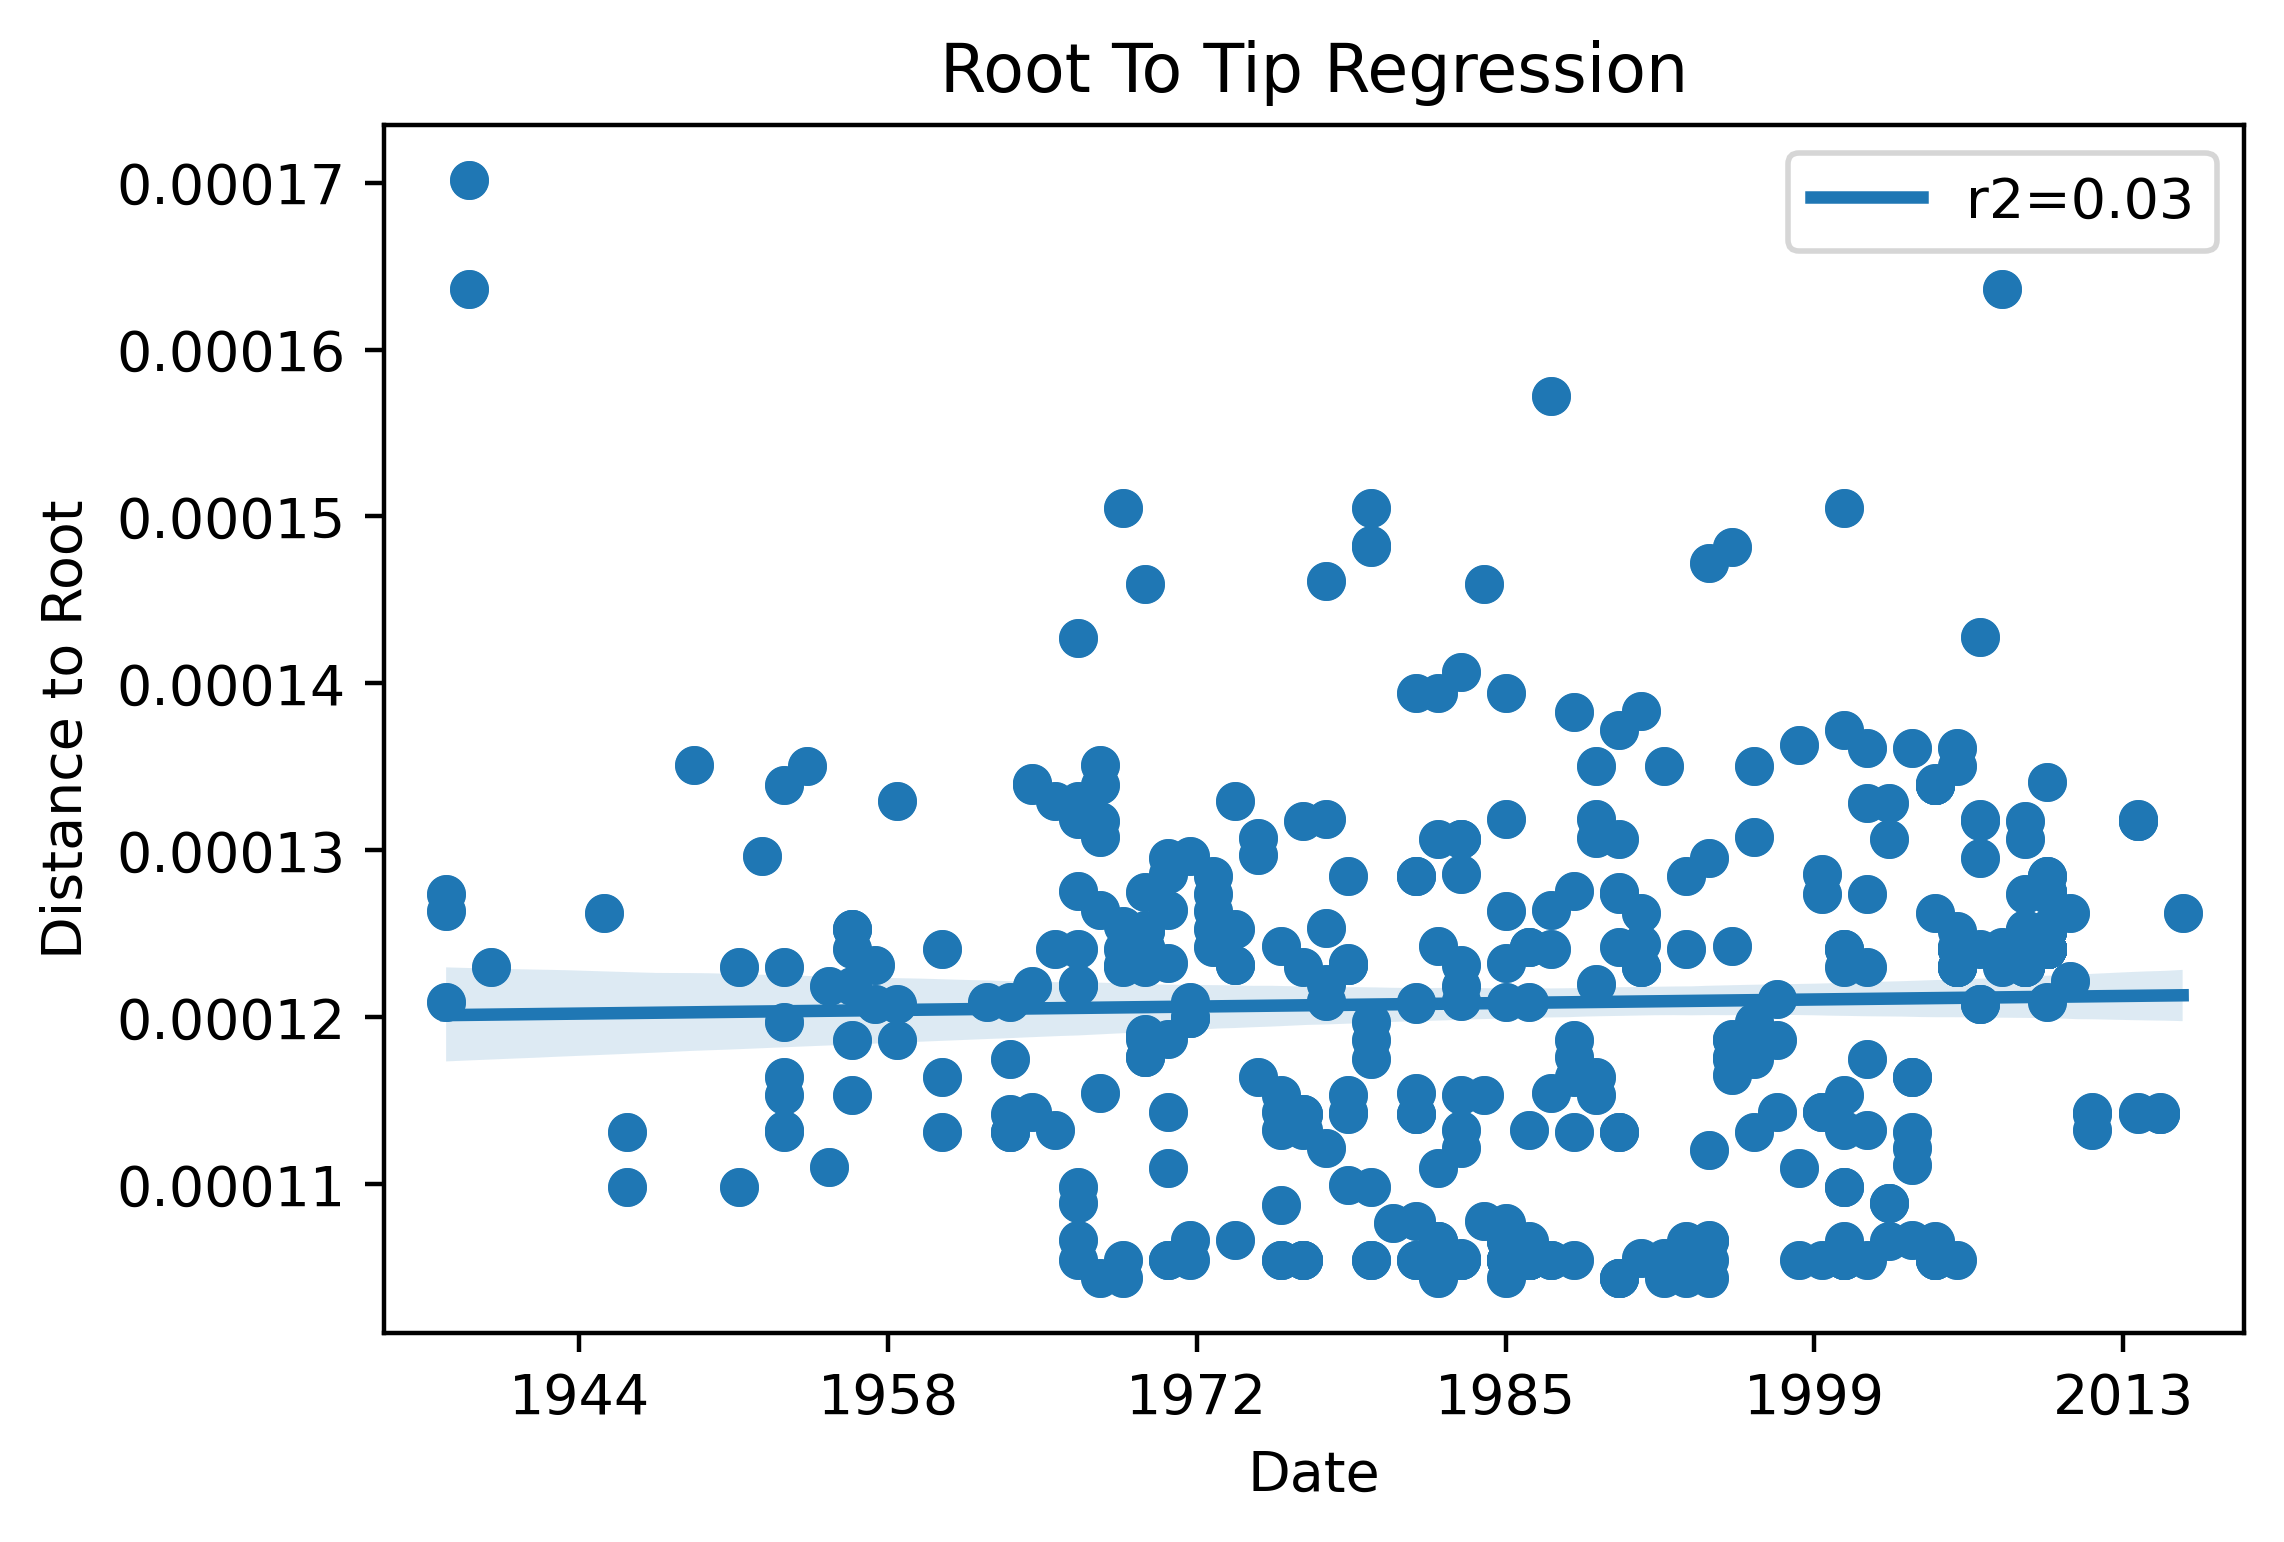

In [11]:
plt.figure(dpi=400)
points = plt.scatter(x=df['date_ordinal'], 
                    y=df['dist2root'])

slope, intercept, r_value, p_value, std_err = stats.linregress(df['date_ordinal'],df['dist2root'])
ax = sns.regplot(x="date_ordinal",
                       y="dist2root",
                       data=df,
                       ci=90,
                       line_kws={'label':"r2={0:.2f}".format(r_value)})
                       #line_kws={'label':"y={0:.2f}x+{1:.2f}".format(slope,intercept)})

ax.set_xlim(df['date_ordinal'].min() - 1000, df['date_ordinal'].max() + 1000)
ax.set_xlabel('Date')
ax.set_ylabel('Distance to Root')

new_labels = [datetime.date.fromordinal(int(item)).year for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
#ax.yaxis.set_major_locator(ticker.MultipleLocator(0.0001))
# plot legend
ax.legend()

ax.set_title("Root To Tip Regression".format(title, slack, coupling))
plt.savefig("{}_rtt.png".format(file_prefix), dpi=400, bbox_inches = "tight")

print("r2: ", r_value)
print("Num Taxa: ", len(full_date))

## Rate Variation

### Setup Data

In [51]:
 # color branches according to the rate deviation
vmin, vmax = min_gamma[1], max_gamma[1]
# Manual override, because max rates are rare
#vmax = 3.0
tt_relaxed_rate = copy.deepcopy(tt_relaxed)



for n in tt_relaxed_rate.tree.find_clades():
    if n.up:
        n.color = [int(x*255) for x in cm.Spectral_r((min(max(vmin, n.branch_length_interpolator.gamma),vmax)-vmin)/(vmax-vmin))[:3]]
    else:
        n.color = [200,200,200]

2159.64	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


<Figure size 2400x1600 with 0 Axes>

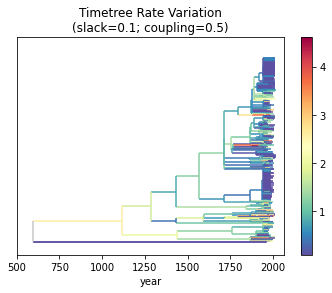

In [52]:
# draw trees inferred with the relaxed model
plt.figure(dpi=400)
fig = plt.figure()
ax = plt.subplot()

# Flip upside down
tt_relaxed_rate.tree.ladderize(reverse=True)
# Convert branch length to years (root date set to 0.1)
tt_relaxed_rate.branch_length_to_years()

# Draw tree to the canvas
Phylo.draw(tt_relaxed_rate.tree, axes=ax, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

# Problem #1: The x axis is not in the range root.numdate t maximum tip_date
# Problem #2: The x axis is in weird increments

step = 250
axis_pad = 50
date_range = np.max([n.numdate for n in tt_relaxed_rate.tree.get_terminals()]) - offset
ax.set_xlim(-axis_pad,date_range+axis_pad)
ax.set_ylim(500,-50)
ax.set_xlabel('year')
ax.set_ylabel('')
ax.set_yticks([])

# Step 1: Figure out offset to convert year branch length to calendar date
min_date = tt_relaxed_rate.tree.root.numdate - tt_relaxed_rate.tree.root.branch_length
offset = abs(min_date)
date_range = np.max([n.numdate for n in tt_relaxed_rate.tree.get_terminals()]) - offset

# Relabel xticks and space them differently

# Distance between ticks
dtick = step
# Minimum tick value
min_tick = step*(offset//step)
# Extra tick increment
extra = dtick if dtick<date_range else dtick
# New tick values
tick_vals = np.arange(min_tick, min_tick+date_range+extra, dtick)
# New tick locations
tick_locs = tick_vals - offset
# New tick labels
tick_labels = ["%d"%(int(x)) for x in tick_vals]

# Set the new tick locations and labels
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labels)

fig.colorbar(cm.ScalarMappable(norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax, clip = False),cmap='Spectral_r'), ax=ax)

# Save output
plt.title("Timetree Rate Variation\n(slack={:.1f}; coupling={:.1f})".format(slack, coupling))
plt.savefig("{}_rate-variation.png".format(file_prefix), dpi=400, bbox_inches = "tight")

## Node-Dating

### Setup Data

In [14]:
# Ancient Root Node
# Spyrou et al. (2019) 5727y BP (HPD 95%: 4909–6842)

## Modern Root Node - MRCA of outgroup nodes and anything else ('Reference' will always be present)
# Rascovan et al. : 5135 YBP (-3115)
# Spyrou et al. (2019) : 5237 YBP ()
root_node_calib = 1950 - 5237
root_node = tt_relaxed.tree.root
root_node_conf = tt_relaxed.get_max_posterior_region(root_node, fraction=confidence)
print("root_node: ")
print("\tnumdate: ", root_node.numdate)
print("\tconf: ", root_node_conf)
print("\tcalib: ", root_node_calib)
print("\n")

# RT5 Node, Polytomy of 0.PE2 (n=20, FSU), 0.PE4 (n=2, China), (n=13, China, FSU)
# Spyrou et al. 4011y BP (HPD 95%: 3760–4325)
# 3 nodes: 0.PE4 (n=2) and Reference (CO92)
rt_node_calib = 1950 - 4011
rt_node = tt_relaxed.tree.common_ancestor(["GCA_000320425.1_ASM32042v1_genomic","GCA_000323625.1_ASM32362v1_genomic", "Reference"])
rt_node_conf = tt_relaxed.get_max_posterior_region(rt_node, fraction=confidence)
print("rt_node: ")
print("\tnumdate: ", rt_node.numdate)
print("\tconf: ", rt_node_conf)
print("\tcalib: ", rt_node_calib)
print("\n")

# Justinian Node
# 3 nodes, Ulgeica (Mongolia) and Reference (CO92)
just_node_calib = 2020 - 1959
just_node_before = tt_relaxed.tree.common_ancestor(["GCA_006546725.1_ASM654672v1_genomic", "GCA_006517425.1_ASM651742v1_genomic", "Reference"])
just_node_before_conf = tt_relaxed.get_max_posterior_region(just_node_before, fraction=confidence)
just_node_after = tt_relaxed.tree.common_ancestor(["GCA_000323665.1_ASM32366v1_genomic", "GCA_000324185.1_ASM32418v1_genomic", "Reference"])
just_node_after_conf = tt_relaxed.get_max_posterior_region(just_node_after, fraction=confidence)
just_node_date = (just_node_after_conf[1] + just_node_before_conf[0]) /2

print("just_node: ")
print("\tnumdate: ", just_node_date)
print("\tconf: ", [just_node_before_conf[0],just_node_after_conf[1]])
print("\tcalib: ", just_node_calib)
print("\n")

## Big Bang (Black Death) Node
# Spyrou et al. (2019) : 754 YBP
# 2 nodes: A Medievalis strain (C-791) and Reference (CO92)
bd_node_calib = 1950 - 754
bd_node = tt_relaxed.tree.common_ancestor(["GCA_001617705.1_Yersinia_pestis_C-791_genomic", "Reference"])
bd_node_conf = tt_relaxed.get_max_posterior_region(bd_node, fraction=confidence)
print("bd_node: ")
print("\tnumdate: ", bd_node.numdate)
print("\tconf: ", bd_node_conf)
print("\tcalib: ", bd_node_calib)
print("\n")

# Modern 
# 3 nodes, India195, Indonesia, Reference (CO92)
modern_node_calib = 1894
modern_node =  tt_relaxed.tree.common_ancestor(["GCA_000182505.1_ASM18250v1_genomic", "GCA_000834905.1_ASM83490v1_genomic", "Reference"])
modern_node_conf = tt_relaxed.get_max_posterior_region(modern_node, fraction=confidence)
print("modern_node: ")
print("\tnumdate: ", modern_node.numdate)
print("\tconf: ", modern_node_conf)
print("\tcalib: ", modern_node_calib)
print("\n")

## Reference Node
ref_node = tt_relaxed.tree.common_ancestor("Reference")

# Scatter plot of node dates
list_node_name = ["Modern Root", "RT5", "Justinian", "Black Death", "Modern Pandemic"]
list_calib_date = [root_node_calib, rt_node_calib, just_node_calib, bd_node_calib, modern_node_calib]
list_estimate_date = [root_node.numdate, rt_node.numdate, just_node_date, bd_node.numdate, modern_node.numdate]
list_lower_conf = [root_node_conf[0], rt_node_conf[0], just_node_before_conf[0], bd_node_conf[0], modern_node_conf[0]]
list_upper_conf = [root_node_conf[1], rt_node_conf[1], just_node_after_conf[1], bd_node_conf[1], modern_node_conf[1]]

# Lists for error bar calculations
list_lower_diff = []
list_upper_diff = []

zip_estimate_lower = zip(list_estimate_date, list_lower_conf)
for list1_i, list2_i in zip_estimate_lower:
    list_lower_diff.append(list1_i-list2_i)
    
zip_estimate_upper = zip(list_upper_conf, list_estimate_date)
for list1_i, list2_i in zip_estimate_upper:
    list_upper_diff.append(list1_i-list2_i)

root_node: 
	numdate:  593.0407848313675
	conf:  [457.8727949  767.34030722]
	calib:  -3287


rt_node: 
	numdate:  1288.2133340322218
	conf:  [1208.73008242 1388.72066823]
	calib:  -2061


just_node: 
	numdate:  1484.660847948975
	conf:  [1343.953624070144, 1625.3680718278058]
	calib:  61


bd_node: 
	numdate:  1713.8320076828816
	conf:  [1707.7597237  1737.25025528]
	calib:  1196


modern_node: 
	numdate:  1890.4012974019383
	conf:  [1886.80487618 1890.4012974 ]
	calib:  1894




### Plot

/home/ktmeaton/miniconda3/envs/nextstrain-8.0.0/lib/python3.6/site-packages/matplotlib/collections.py:988: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


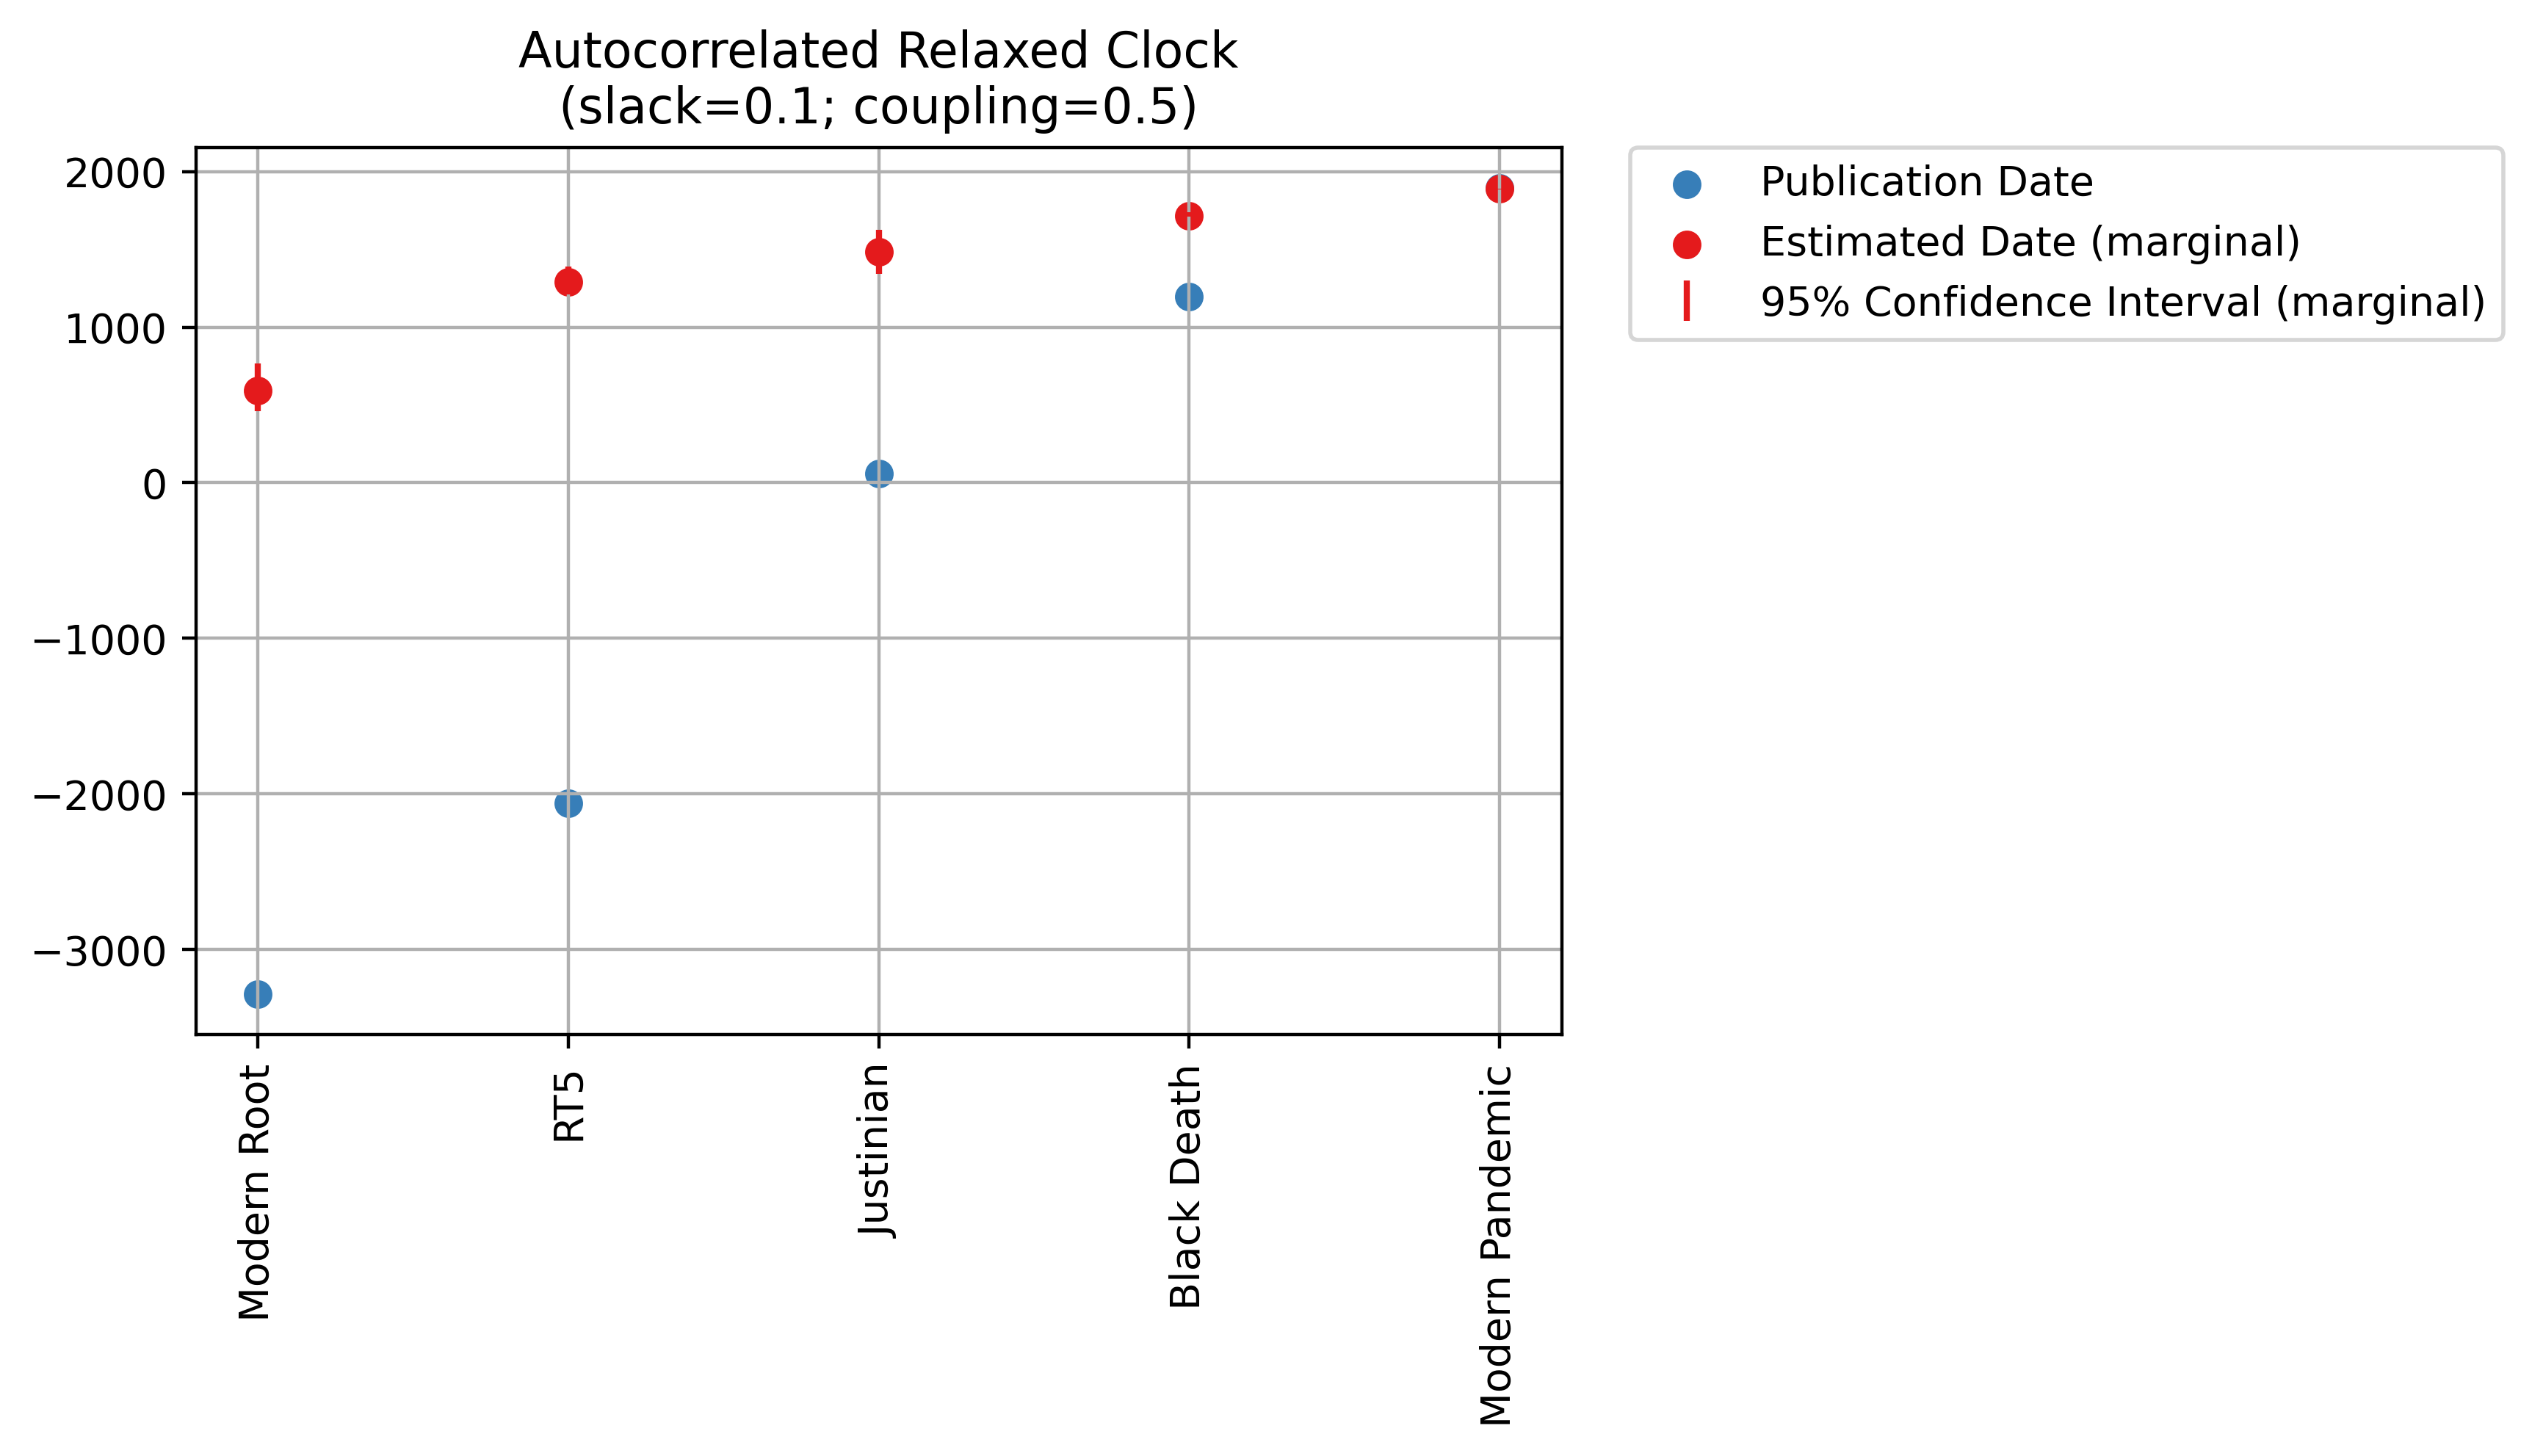

In [15]:
plt.figure(dpi=400)
ax = plt.subplot()

# Confidence Interval
plt.errorbar(
    x=list_node_name,
    y=list_estimate_date,
    yerr=[list_lower_diff, list_upper_diff],
    linestyle='',
    c="#e41a1c",
    label="{0:.0f}% Confidence Interval (marginal)".format(confidence * 100),
)

# Sampling date scatter plot
scatter_sample = plt.scatter(x=list_node_name, y=list_calib_date, c="#377eb8", label = "Publication Date")

# Estimated date scatter plot
plt.scatter(x=list_node_name, y=list_estimate_date, c="#e41a1c", label = "Estimated Date ({})".format(ml_mode), )

#perc_string = "{0:.0f}% of confidence intervals \ncontain sampling date".format(perc_ci_contain_sample_date)
                                                                                
# Add text
#plt.text(1.05, 0.5, 
#         perc_string, 
#         horizontalalignment='left', 
#         verticalalignment='center', 
#         transform=ax.transAxes)

# Formatting
plt.xticks(rotation=90)
plt.grid(True)

# Place a legend to the right of this smaller subplot.
legend1 = plt.legend(handles=scatter_sample.legend_elements()[0],
                     labels= [""],
                     bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


#plt.gca().add_artist(legend1)
# Title
plt.title("{}\n(slack={:.1f}; coupling={:.1f})".format(title, slack, coupling))
plt.savefig("{}_note-dating.png".format(file_prefix), dpi=400, bbox_inches = "tight")

## Skyline

<Figure size 2400x1600 with 0 Axes>

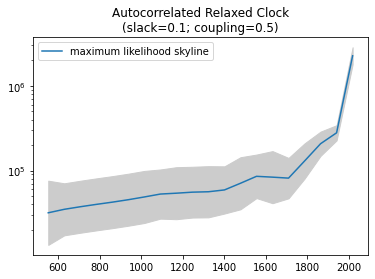

In [16]:
skyline, conf = tt_relaxed.merger_model.skyline_inferred(gen=50, confidence=2)

plt.figure(dpi=400)
fig = plt.figure()
ax = plt.subplot()

plt.fill_between(skyline.x, conf[0], conf[1], color=(0.8, 0.8, 0.8))
plt.plot(skyline.x, skyline.y, label='maximum likelihood skyline')
plt.yscale('log')
plt.legend()
plt.ticklabel_format(axis='x',useOffset=False)

ax.set_title("{}\n(slack={:.1f}; coupling={:.1f})".format(title, slack, coupling))
plt.savefig("{}_skyline.png".format(file_prefix), dpi=400)

# Write Output Trees

In [17]:
# Figtree compatible timetrees
tt_relaxed_plain = copy.deepcopy(tt_relaxed)
# Divergence tree
tt_relaxed_div = copy.deepcopy(tt_relaxed)

# Write timetrees
Phylo.write(tt_relaxed.tree, open("{}_timetree.nexus".format(file_prefix), "w"), "nexus", format_branch_length='%1.10f')
Phylo.write(tt_relaxed.tree, open("{}_timetree.newick".format(file_prefix), "w"), "newick", format_branch_length='%1.10f')
#----------------

# Figtree compatible timetrees
for c in tt_relaxed_plain.tree.find_clades():
    # Make sure all branches have length (not None)
    if c.branch_length is None:
        c.branch_length = 0
    # Remove internal node names
    if not c.is_terminal():
        c.name = None
        
Phylo.write(tt_relaxed_plain.tree, open("{}_timetree-plain.nexus".format(file_prefix), "w"), "nexus", format_branch_length='%1.10f')     
#------------------

# Write divergence trees
for c in tt_relaxed_div.tree.find_clades():
    c.branch_length = c.mutation_length

Phylo.write(tt_relaxed_div.tree, open("{}_divtree.nexus".format(file_prefix), "w"), 'nexus', format_branch_length='%1.10f')
Phylo.write(tt_relaxed_div.tree, open("{}_divtree.nwk".format(file_prefix), "w"), 'newick', format_branch_length='%1.10f')
#-------------------

# Figtree compatible divergence trees
for c in tt_relaxed_div.tree.find_clades():
    # Make sure all branches have length (not None)
    if c.branch_length is None:
        c.branch_length = 0
    # Remove internal node names
    if not c.is_terminal():
        c.name = None

Phylo.write(tt_relaxed_div.tree, open("{}_divtree-plain.nexus".format(file_prefix), "w"), "nexus", format_branch_length='%1.10f')    

1